## Imports

In [ ]:
import numpy as np
import gc
from tqdm.notebook import tqdm
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/MyDrive/study/andan/dl_2_lab_mnist/'

Mounted at /content/drive


## Data

In [ ]:
# values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation of the MNIST dataset

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(
    (0.1307,), (0.3081,))
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=16, shuffle = True, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=16, shuffle = False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.17MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 8.83MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.17MB/s]


In [ ]:
transform = transforms.Compose([
  transforms.ToTensor()
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader_fm = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle = True, pin_memory=True, num_workers=2)
test_loader_fm = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle = False)

100%|██████████| 26.4M/26.4M [00:00<00:00, 115MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 4.06MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 60.9MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.54MB/s]


In [ ]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Functions

In [ ]:
class ConvPoolLeakyReLU(nn.Module):
    """ Блок свёртки и пулинга со skip-connection и сложением на конце"""
    def __init__(self, in_size, out_size, conv_kernel_size=3, pad=1, norm=True, pool_kernel_size=2, dropout=True, p=0.2):
        super().__init__()
        self.dropout = dropout
        self.norm = norm

        self.conv = nn.Conv2d(
            in_channels=in_size,
            out_channels=out_size,
            kernel_size=conv_kernel_size,
            padding=pad
        )
        self.leaky_relu = nn.LeakyReLU()
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size)
        self.drop2d = nn.Dropout2d(p=p)
        self.norm2d = nn.BatchNorm2d(out_size)

    def forward(self, x):
        x = self.conv(x)
        if self.dropout:
          x = self.drop2d(x)
        x = self.pool(x)
        x = self.leaky_relu(x)
        if self.norm:
          x = self.norm2d(x)
        return x

In [ ]:
class CommonConvTrans(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvPoolLeakyReLU(1,   10)
        self.conv2 = ConvPoolLeakyReLU(10,  20)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [ ]:
class ClMnistHead(nn.Module):
    def __init__(self, in_size, n_classes):
        super().__init__()
        self.fc1 = nn.Sequential(
                      nn.Linear(in_features=in_size, out_features=256, ),
                      nn.LeakyReLU(),
                      nn.Dropout(0.2))
        self.norm1d =  nn.BatchNorm1d(256)
        self.out = nn.Sequential(
                      nn.Linear(in_features=256, out_features=n_classes)
                      )


    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.norm1d(x)
        x = self.out(x)
        return x

In [ ]:
class FashionMnistHead(nn.Module):
    def __init__(self, in_size, n_classes):
        super().__init__()
        self.fc1 = nn.Sequential(
                      nn.Linear(in_features=in_size, out_features=256, ),
                      nn.LeakyReLU(),
                      nn.Dropout(0.2))
        self.norm1d =  nn.BatchNorm1d(256)
        self.out = nn.Sequential(
                      nn.Linear(in_features=256, out_features=n_classes)
                      )


    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.norm1d(x)
        x = self.out(x)
        return x

In [ ]:
class ClMnistCNN(nn.Module):
    def __init__(self, n_classes, common_conv=None, freeze_common_conv=False, head=None, freeze_head=False):
        super().__init__()
        self.common_conv = common_conv

        if self.common_conv is None:
            self.common_conv = CommonConvTrans()

        if freeze_common_conv:
            for param in self.common_conv.parameters():
                param.requires_grad = False

        self.head = head

        if self.head is None:
            self.head = ClMnistHead(980, 10)

        if freeze_head:
            for param in self.head.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.common_conv(x)
        x = self.head(x)
        return x

In [ ]:
class FashionMnistCNN(nn.Module):
    def __init__(self, n_classes, common_conv=None, freeze_common_conv=False, head=None, freeze_head=False):
        super().__init__()
        self.common_conv = common_conv

        if self.common_conv is None:
            self.common_conv = CommonConvTrans()

        if freeze_common_conv:
            for param in self.common_conv.parameters():
                param.requires_grad = False

        self.head = head

        if self.head is None:
            self.head = FashionMnistHead(980, n_classes)

        if freeze_head:
            for param in self.head.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.common_conv(x)
        x = self.head(x)
        return x

In [ ]:
device = torch.device('gpu')
print(torch.cuda.is_available())

True


In [ ]:
def test(net, test_loader):
    with torch.no_grad():
        accuracy = []
        for batch in test_loader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            y_pred = net(x)
            accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
        accuracy_mean = np.mean(np.array(accuracy))
        return accuracy_mean

In [ ]:
def train(net, train_loader, test_loader, save_path, n_epoch=10):
    log = {}
    log['accuracy_test_every_500_batch'] = []
    log['accuracy_train_every_500_batch'] = []
    log['accuracy_test_per_epoch'] = []
    log['accuracy_train_per_epoch'] = []
    log['loss_every_500_batch'] = []

    loss_fn = torch.nn.CrossEntropyLoss()

    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    best_accuracy = 0
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(train_dataiter):
            X_batch, y_batch = batch
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()

            y_pred = net(X_batch)
            loss = loss_fn(y_pred, y_batch)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 500 == 499:
                # print('[%d, %5d] loss: %.3f' %
                #         (epoch + 1, i + 1, running_loss / 500))
                log['loss_every_500_batch'].append(running_loss / 500)
                log['accuracy_test_every_500_batch'].append(test(net, test_loader))
                log['accuracy_train_every_500_batch'].append(test(net, train_loader))
                running_loss = 0.0

        accuracy = test(net, test_loader)
        log['accuracy_test_per_epoch'].append(accuracy)
        log['accuracy_train_per_epoch'].append(test(net, train_loader))
        if accuracy > best_accuracy:
            print('New best model with test acc:', accuracy)
            torch.save(net.state_dict(), save_path)
            best_accuracy = accuracy
    print('Обучение закончено')
    return net, log

In [ ]:
def print_params(net):
    return list(net.parameters())

In [ ]:
def plot_lc_loss_batch(ax, train_loss):
    # ax.figure(figsize=(10, 5))
    ax.plot(train_loss, label=f'train loss')
    # ax.plot(test_loss, label=f'test loss')
    ax.set_xlabel('X 500 batch')
    ax.set_ylabel('Loss')
    ax.legend()

def plot_lc_accuracy_batch(ax, train_accuracy, test_accuracy):
    # ax.figure(figsize=(10, 5))
    ax.plot(train_accuracy, label=f'train accuracy')
    ax.plot(test_accuracy, label=f'test accuracy')
    ax.set_xlabel('X 500 batch')
    ax.set_ylabel('accuracy')
    ax.set_title('Learning Curve')
    ax.legend()

def plot_lc_accuracy_epoch(ax, train_accuracy, test_accuracy):
    # ax.figure(figsize=(10, 5))
    ax.plot(train_accuracy, label=f'train accuracy')
    ax.plot(test_accuracy, label=f'test accuracy')
    ax.set_xlabel('X 500 batch')
    ax.set_ylabel('accuracy')
    ax.legend()

def plot_lc(log):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
    plot_lc_loss_batch(ax1, log['loss_every_500_batch'])
    plot_lc_accuracy_batch(ax2, log['accuracy_train_every_500_batch'], log['accuracy_test_every_500_batch'])
    plot_lc_accuracy_epoch(ax3, log['accuracy_train_per_epoch'], log['accuracy_test_per_epoch'])
    plt.show()

In [ ]:
def present_logits(net, test_loader):
    with torch.no_grad():
        logits = []
        ans_pred = np.array([], dtype=int)
        ans_real = np.array([], dtype=int)
        for batch in test_loader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            y_pred = net(x)
            logits.extend(y_pred.detach().cpu().numpy())
            ans_pred = np.concatenate([ans_pred, np.argmax(y_pred.detach().cpu().numpy(), axis=1)])
            ans_real = np.concatenate([ans_real, y.detach().cpu().numpy()])
        return ans_pred, ans_real, logits

def find_unequal_indices(y_pred, y_real):
    ans_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
    unequal_indices = []
    for i in range(len(y_pred)):
        if y_pred[i] != y_real[i]:
            ans_dict[y_real[i]].append(i)
    return ans_dict

def get_best_bad_elements_and_indices(data, indices):
  ans_dict = {0: (-np.inf, -1), 1: (-np.inf, -1), 2: (-np.inf, -1), 3: (-np.inf, -1), 4: (-np.inf, -1), 5: (-np.inf, -1), 6: (-np.inf, -1), 7: (-np.inf, -1), 8: (-np.inf, -1), 9: (-np.inf, -1)}
  for index in indices:
      to_f = data[index]
      argm = np.argmax(to_f)
      if ans_dict[argm][0] < to_f[argm]:
          ans_dict[argm] = (to_f[argm], index)
  return ans_dict


def plot_images_in_matrix(images, indices):

    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    fig.text(0.5, 0.04, 'predicted', ha='center')
    fig.text(0, 0.5,'real', va='center', rotation='vertical')

    for i in range(10):
        for j in range(10):
            axes[i, j].axis('off')

    for row in range(10):
        row_id = indices[row]
        for col in range(10):
            id2 = row_id[col]
            if id2[1] < 0:
                continue
            axes[row, col].imshow(images[id2[1]][0].reshape((28, 28)), cmap='gray')

    for i in range(10):
        axes[i, 0].axis('on')
        axes[i, 0].set_ylabel(class_names[i], fontsize=7)
        axes[0, i].set_title(class_names[i], fontsize=7)
    plt.show()

def nine_task(net, test_loader, test_data):
    y_pred, y_real, logits = present_logits(net, test_loader)
    bad_id = find_unequal_indices(y_pred, y_real)
    indeces = {}
    for i in range(10):
        indeces[i] = get_best_bad_elements_and_indices(logits, bad_id[i])
    plot_images_in_matrix(test_data, indeces)

## MNIST

### 4. Обучите архитектуру и постройте кривую обучения для тренировочного и тестового множества. Используйте целевую функцию для задачи классификации.

In [ ]:
net, log = train(ClMnistCNN(n_classes=10).cuda(), train_loader, test_loader, root + "model_classic_mnist.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

New best model with test acc: 0.9637
New best model with test acc: 0.9729
New best model with test acc: 0.9746
New best model with test acc: 0.9751
New best model with test acc: 0.9788
New best model with test acc: 0.9804
New best model with test acc: 0.983
Обучение закончено


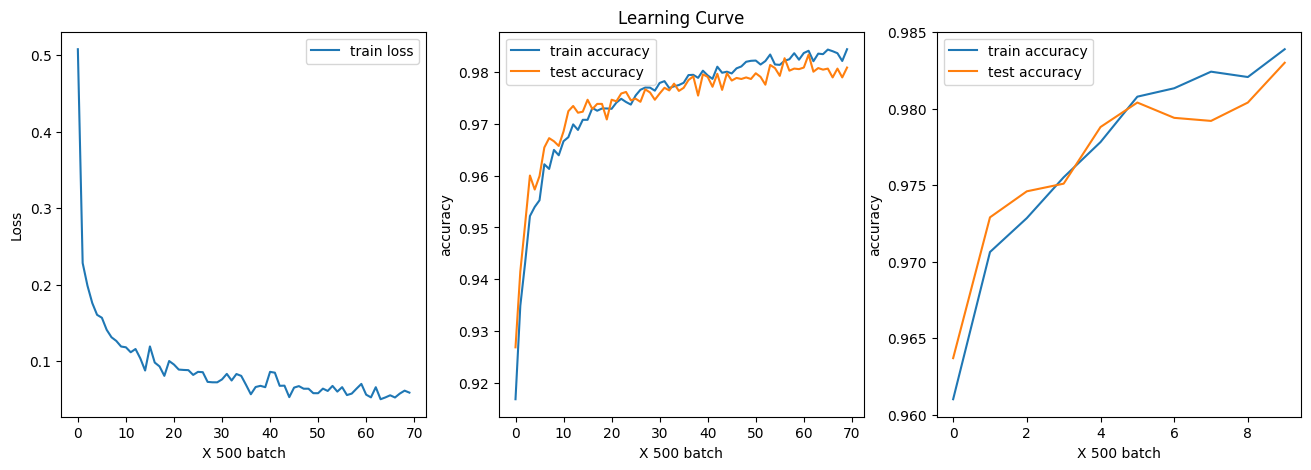

In [ ]:
# постройте кривую обучения для тренировочного и тестового множества
plot_lc(log)

In [ ]:
torch.cuda.empty_cache()
gc.collect()

38778

## FasionMNIST

### 5. Добавьте в архитектуру новую «голову». Сохраните значения всех обучаемых параметров: общих свёрточных слоёв, первой и ещё не обученной второй «головы».


In [ ]:
cnn_classic_mnist = ClMnistCNN(10)
cnn_classic_mnist.load_state_dict(torch.load(root + 'model_classic_mnist.pt', map_location=torch.device('cpu')))
test(cnn_classic_mnist, test_loader)

np.float64(0.9816)

In [ ]:
# общих свёрточных слоёв
torch.save(cnn_classic_mnist.common_conv.state_dict(), root + "common_conv_trans.pt")
print("Common Trasformations")
print(cnn_classic_mnist.common_conv)

# первая голова
torch.save(cnn_classic_mnist.head.state_dict(), root + "mnist_head.pt")
print("First (Mnist) Head")
print(cnn_classic_mnist.head)

Common Trasformations
CommonConvTrans(
  (conv1): ConvPoolLeakyReLU(
    (conv): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leaky_relu): LeakyReLU(negative_slope=0.01)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop2d): Dropout2d(p=0.2, inplace=False)
    (norm2d): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): ConvPoolLeakyReLU(
    (conv): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leaky_relu): LeakyReLU(negative_slope=0.01)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop2d): Dropout2d(p=0.2, inplace=False)
    (norm2d): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
First (Mnist) Head
ClMnistHead(
  (fc1): Sequential(
    (0): Linear(in_features=980, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inpla

In [ ]:
# параметры общих свёрточных преобразований должны быть заморожены
fashion_head_only_net = deepcopy(cnn_classic_mnist)
for param in fashion_head_only_net.parameters():
    param.requires_grad = False

# новая «голова»
fashion_head_only_net.head = FashionMnistHead(980, 10)
list(fashion_head_only_net.parameters())

[Parameter containing:
 tensor([[[[ 0.0617,  0.2741,  0.0035],
           [ 0.1733,  0.5655, -0.0153],
           [-0.2194,  0.0644, -0.5011]]],
 
 
         [[[ 0.1650,  0.1566, -0.1683],
           [-0.1952,  0.4122,  0.1682],
           [-0.2600, -0.0268,  0.2574]]],
 
 
         [[[-0.3136, -0.0707,  0.4352],
           [-0.5494,  0.3138,  0.1546],
           [-0.1640, -0.1510,  0.1261]]],
 
 
         [[[-0.0578, -0.3884, -0.2576],
           [-0.4443, -0.0448,  0.1866],
           [-0.0275,  0.1297,  0.2264]]],
 
 
         [[[ 0.2064, -0.0410, -0.5000],
           [ 0.1379,  0.0293, -0.1072],
           [ 0.1106,  0.1171,  0.2557]]],
 
 
         [[[ 0.5013,  0.1170,  0.1898],
           [ 0.4331,  0.0765, -0.2733],
           [-0.1601, -0.1156, -0.4128]]],
 
 
         [[[-0.2961, -0.1975,  0.1741],
           [ 0.1395,  0.4025,  0.0658],
           [ 0.1761, -0.0209, -0.2201]]],
 
 
         [[[ 0.1122,  0.3042,  0.3965],
           [ 0.0456, -0.0651, -0.0810],
           [-0.

In [ ]:
# Сохраните значения ещё не обученной второй «головы»
torch.save(fashion_head_only_net.head.state_dict(), root + "fm_mnist_head_not_lr.pt")
print("Second (FashionMnist) Head No Learning")
print(fashion_head_only_net.head)

Second (FashionMnist) Head No Learning
FashionMnistHead(
  (fc1): Sequential(
    (0): Linear(in_features=980, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
  )
  (norm1d): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
)


### 6. Обучите вторую «голову» для классификации второго набора данных. При этом параметры общих свёрточных преобразований должны быть заморожены. Постройте кривые обучения для второй задачи.


In [ ]:
# Обучите вторую «голову»

fashion_head_only_net, fashion_head_only_net_log = train(fashion_head_only_net.cuda(), train_loader_fm, test_loader_fm, root + "fashion_head_only_net.pt")
test(fashion_head_only_net, test_loader_fm)

  0%|          | 0/10 [00:00<?, ?it/s]

New best model with test acc: 0.7976
New best model with test acc: 0.8125
New best model with test acc: 0.8168
New best model with test acc: 0.8192
New best model with test acc: 0.8281
New best model with test acc: 0.8325
Обучение закончено


np.float64(0.832)

In [ ]:
torch.save(fashion_head_only_net.head.state_dict(), root + "fashion_mnist_head_1.pt")
print("Second (FashionMnist) Head Only Learning")
print(fashion_head_only_net.head)

Second (FashionMnist) Head Only Learning
FashionMnistHead(
  (fc1): Sequential(
    (0): Linear(in_features=980, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
  )
  (norm1d): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
)


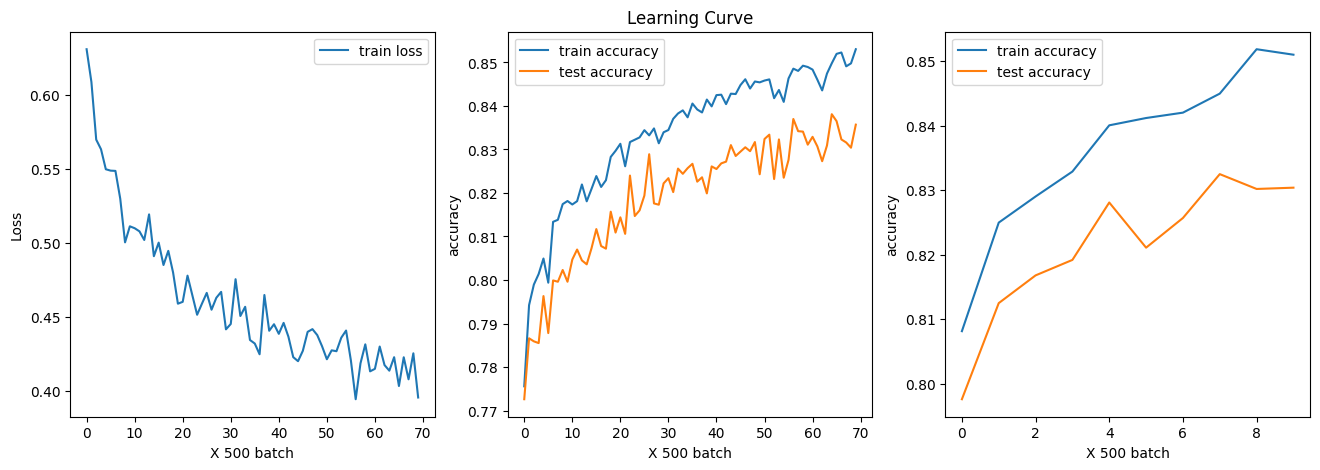

In [ ]:
plot_lc(fashion_head_only_net_log)

In [ ]:
torch.cuda.empty_cache()
gc.collect()

16620

### 7. Разморозьте параметры общих свёрточных преобразований и дообучите вторую голову. Постройте кривые обучения для первой и второй задачи.

In [ ]:
fashion_head_only_net = FashionMnistCNN(10)
fashion_head_only_net.load_state_dict(torch.load(root + 'fashion_head_only_net.pt', map_location=torch.device('cpu')))
test(fashion_head_only_net, test_loader_fm)

np.float64(0.8295)

In [ ]:
fashion_unfreese_conv = deepcopy(fashion_head_only_net)

# Разморозьте параметры общих свёрточных преобразований
for param in fashion_unfreese_conv.common_conv.parameters():
    param.requires_grad = True

print_params(fashion_unfreese_conv)

[Parameter containing:
 tensor([[[[ 0.0617,  0.2741,  0.0035],
           [ 0.1733,  0.5655, -0.0153],
           [-0.2194,  0.0644, -0.5011]]],
 
 
         [[[ 0.1650,  0.1566, -0.1683],
           [-0.1952,  0.4122,  0.1682],
           [-0.2600, -0.0268,  0.2574]]],
 
 
         [[[-0.3136, -0.0707,  0.4352],
           [-0.5494,  0.3138,  0.1546],
           [-0.1640, -0.1510,  0.1261]]],
 
 
         [[[-0.0578, -0.3884, -0.2576],
           [-0.4443, -0.0448,  0.1866],
           [-0.0275,  0.1297,  0.2264]]],
 
 
         [[[ 0.2064, -0.0410, -0.5000],
           [ 0.1379,  0.0293, -0.1072],
           [ 0.1106,  0.1171,  0.2557]]],
 
 
         [[[ 0.5013,  0.1170,  0.1898],
           [ 0.4331,  0.0765, -0.2733],
           [-0.1601, -0.1156, -0.4128]]],
 
 
         [[[-0.2961, -0.1975,  0.1741],
           [ 0.1395,  0.4025,  0.0658],
           [ 0.1761, -0.0209, -0.2201]]],
 
 
         [[[ 0.1122,  0.3042,  0.3965],
           [ 0.0456, -0.0651, -0.0810],
           [-0.

In [ ]:
# дообучите вторую голову

fashion_unfreese_conv_net, fashion_unfreese_conv_log = train(fashion_unfreese_conv, train_loader_fm, test_loader_fm, root + "fashion_unfreese_conv.pt", 10)
test(fashion_unfreese_conv_net, test_loader_fm)

  0%|          | 0/10 [00:00<?, ?it/s]

New best model with test acc: 0.8519
New best model with test acc: 0.8663
New best model with test acc: 0.8717
New best model with test acc: 0.8726
New best model with test acc: 0.8799
New best model with test acc: 0.8811
New best model with test acc: 0.8831
New best model with test acc: 0.886
Обучение закончено


np.float64(0.888)

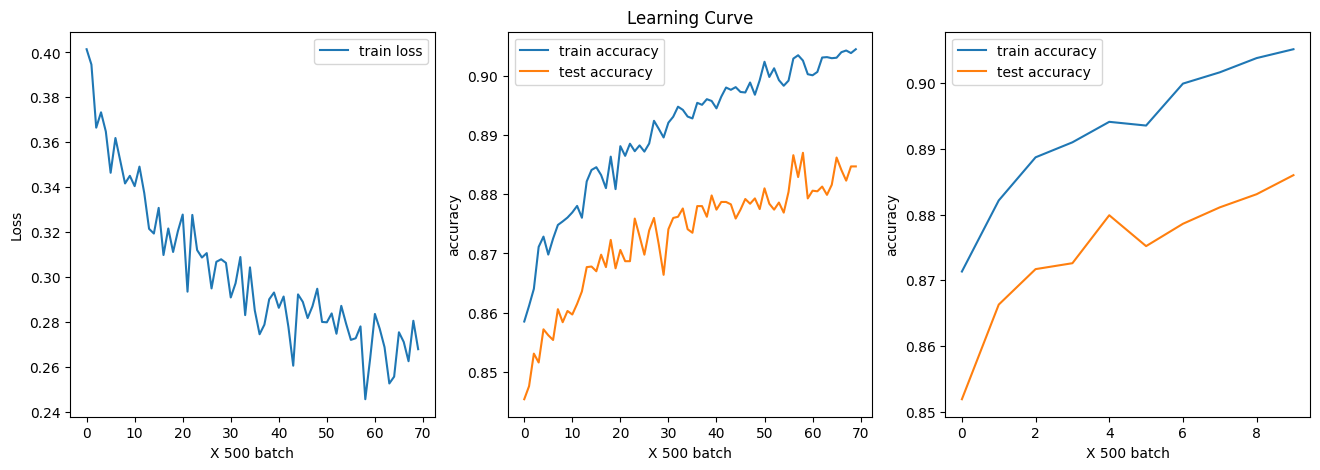

In [ ]:
plot_lc(fashion_unfreese_conv_log)

In [ ]:
torch.cuda.empty_cache()
gc.collect()

10339

In [ ]:
# Постройте кривые обучения для первой и второй задачи

### 8. Загрузите сохранённые параметры для всех преобразований. Обучите вторую голову, при этом параметры общих свёрточных преобразований должны быть сразу разморожены. Постройте кривые обучения для первой и второй задачи.

In [ ]:
# Загрузите сохранённые параметры для всех преобразований

In [ ]:
# Обучите вторую голову свертка размарожена сразу

fm_conv_not_freese = deepcopy(cnn_classic_mnist)
fm_conv_not_freese.head = FashionMnistHead(980, 10)
print_params(fm_conv_not_freese)

[Parameter containing:
 tensor([[[[ 0.0617,  0.2741,  0.0035],
           [ 0.1733,  0.5655, -0.0153],
           [-0.2194,  0.0644, -0.5011]]],
 
 
         [[[ 0.1650,  0.1566, -0.1683],
           [-0.1952,  0.4122,  0.1682],
           [-0.2600, -0.0268,  0.2574]]],
 
 
         [[[-0.3136, -0.0707,  0.4352],
           [-0.5494,  0.3138,  0.1546],
           [-0.1640, -0.1510,  0.1261]]],
 
 
         [[[-0.0578, -0.3884, -0.2576],
           [-0.4443, -0.0448,  0.1866],
           [-0.0275,  0.1297,  0.2264]]],
 
 
         [[[ 0.2064, -0.0410, -0.5000],
           [ 0.1379,  0.0293, -0.1072],
           [ 0.1106,  0.1171,  0.2557]]],
 
 
         [[[ 0.5013,  0.1170,  0.1898],
           [ 0.4331,  0.0765, -0.2733],
           [-0.1601, -0.1156, -0.4128]]],
 
 
         [[[-0.2961, -0.1975,  0.1741],
           [ 0.1395,  0.4025,  0.0658],
           [ 0.1761, -0.0209, -0.2201]]],
 
 
         [[[ 0.1122,  0.3042,  0.3965],
           [ 0.0456, -0.0651, -0.0810],
           [-0.

In [ ]:
fm_conv_not_freese

ClMnistCNN(
  (common_conv): CommonConvTrans(
    (conv1): ConvPoolLeakyReLU(
      (conv): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (leaky_relu): LeakyReLU(negative_slope=0.01)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (drop2d): Dropout2d(p=0.2, inplace=False)
      (norm2d): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): ConvPoolLeakyReLU(
      (conv): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (leaky_relu): LeakyReLU(negative_slope=0.01)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (drop2d): Dropout2d(p=0.2, inplace=False)
      (norm2d): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (head): FashionMnistHead(
    (fc1): Sequential(
      (0): Linear(in_features=980, out_features=256, bias=True)
      (1): LeakyReLU(negative_sl

In [ ]:
fm_conv_not_freese_net, fm_conv_not_freese_log = train(fm_conv_not_freese, train_loader_fm, test_loader_fm, root + "fm_conv_not_freese.pt")
test(fm_conv_not_freese, test_loader_fm)

  0%|          | 0/10 [00:00<?, ?it/s]

New best model with test acc: 0.8428
New best model with test acc: 0.8627
New best model with test acc: 0.8665
New best model with test acc: 0.8682
New best model with test acc: 0.8752
New best model with test acc: 0.8815
New best model with test acc: 0.8853
Обучение закончено


np.float64(0.8843)

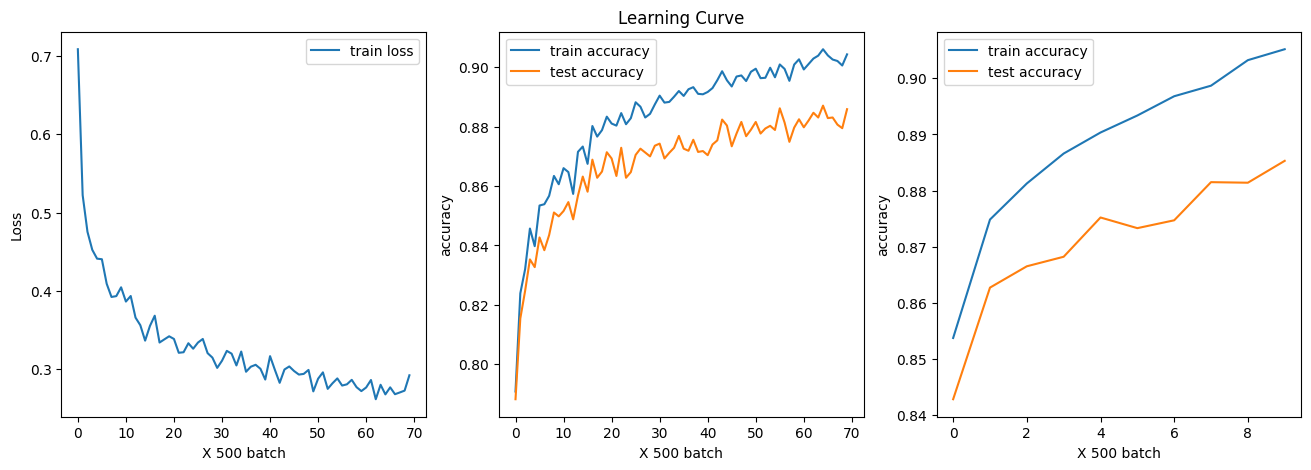

In [ ]:
plot_lc(fm_conv_not_freese_log)

### 9. Опираясь на предсказываемые логиты или вероятности для тестового множества второй задачи, для каждой пары классов c,t найдите изображение класса c, которое больше всего похоже на класс t.

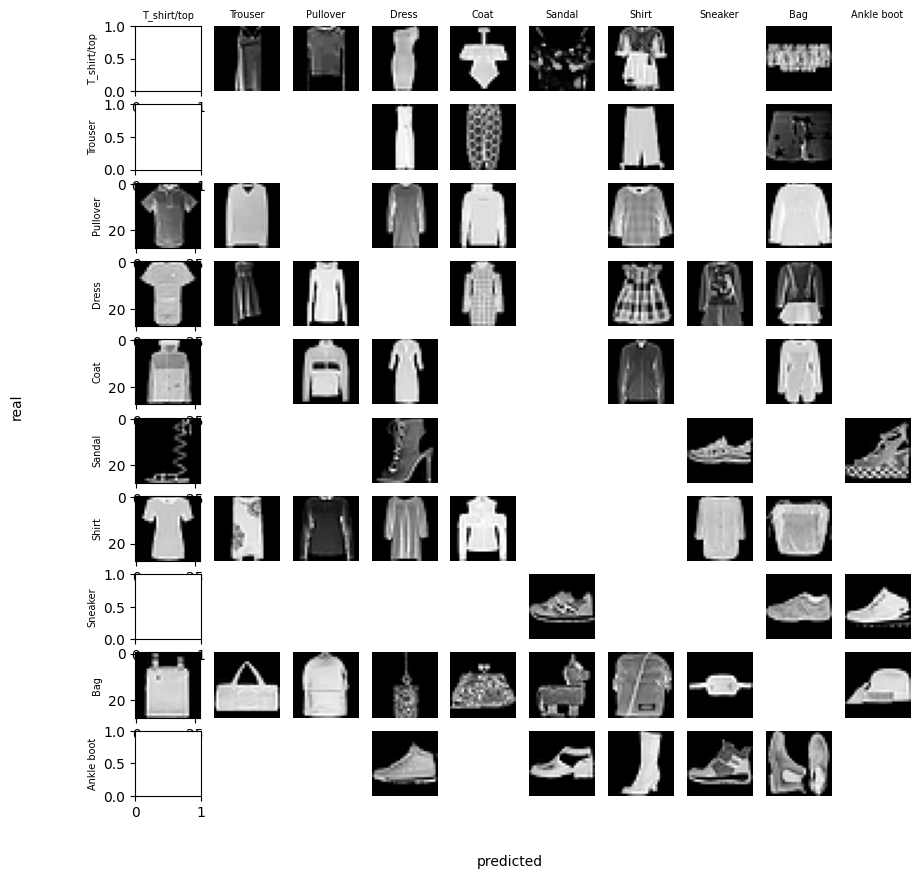

In [ ]:
fashion_head_only_net = FashionMnistCNN(10)
fashion_head_only_net.load_state_dict(torch.load(root + 'fashion_unfreese_conv.pt', map_location=torch.device('cpu')))
nine_task(fashion_head_only_net, test_loader_fm, test_data)

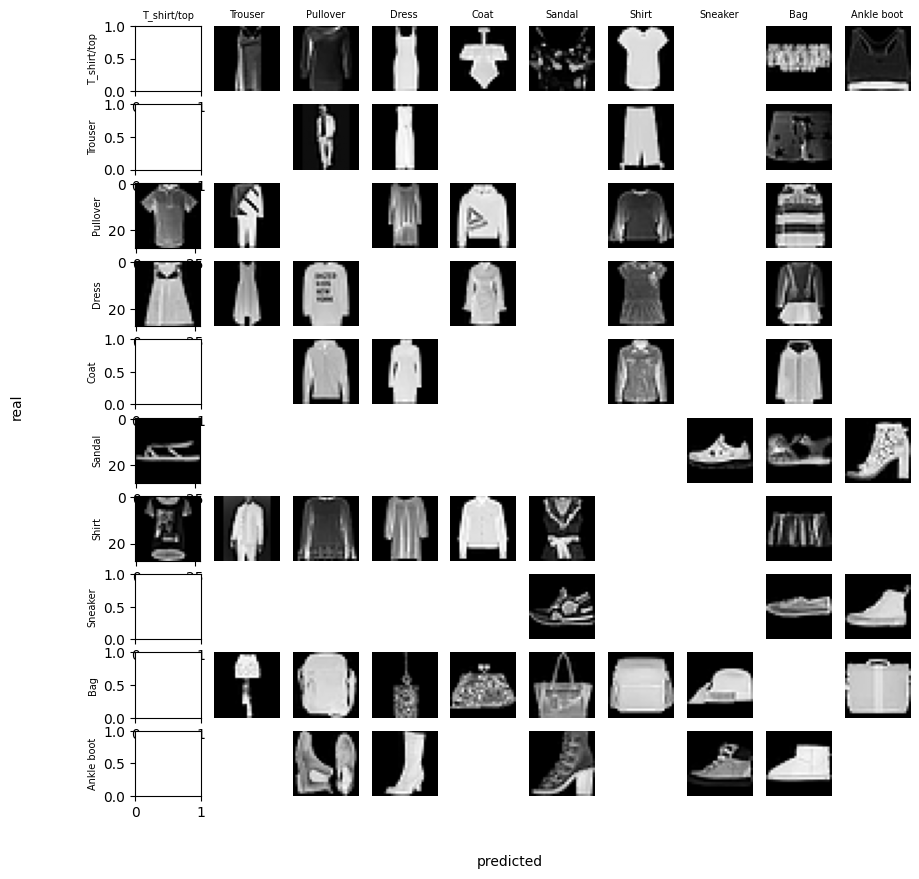

In [ ]:
fm_conv_not_freese_net = FashionMnistCNN(10)
fm_conv_not_freese_net.load_state_dict(torch.load(root + 'fm_conv_not_freese.pt', map_location=torch.device('cpu')))
nine_task(fm_conv_not_freese_net, test_loader_fm,test_data)